# 2023-10-13 More about aperture photometry

## Overview

+ Review pixel counting ideas from last time
+ Overview of getting sky background 
+ Estimating sky background
+ Aperture size

In [1]:
from astropy.modeling.models import Gaussian2D
from astropy.stats import gaussian_sigma_to_fwhm

from matplotlib import pyplot as plt

import numpy as np

from photutils.profiles import RadialProfile, CurveOfGrowth

In [2]:
def image_with_pixels_labeled(image, **text_kwargs):
    image_size = image.shape[0]
    plt.imshow(image)
    plt.colorbar()
    for i in range(image_size):
        for j in range(image_size):
            plt.text(i, j, int(image[j, i]), 
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            plt.scatter(i, j, marker='.', c='red', alpha=0.5)


In [3]:
def circle(x, y, radius):
    angle = np.linspace(0, 2 * np.pi)
    return x + radius * np.cos(angle), y + radius * np.sin(angle)

In [4]:
rng = np.random.default_rng(seed=548975)

In [5]:
figure_size = (20, 20)
image_size = 25
star_center = (12, 12)
sigma = 2  # Gaussian width of the star
background_image = rng.poisson(lam=200, size=[image_size, image_size])

In [6]:
circ = circle(*star_center, 2.1)

## Part 1

### A fake image: background only

In [8]:

fwhm = sigma * gaussian_sigma_to_fwhm

star = Gaussian2D(amplitude=200, x_stddev=sigma, y_stddev=sigma)
grids = np.mgrid[0:image_size, 0:image_size]
star_grid = star(grids[0] - star_center[0], grids[1] - star_center[1])

In [9]:
total_image = background_image + star_grid

In [11]:
new_background_image = rng.poisson(lam=200, size=[image_size, image_size])
new_total_image = new_background_image + star_grid

## Part 1: Star Only

### Star only (another fake image!)

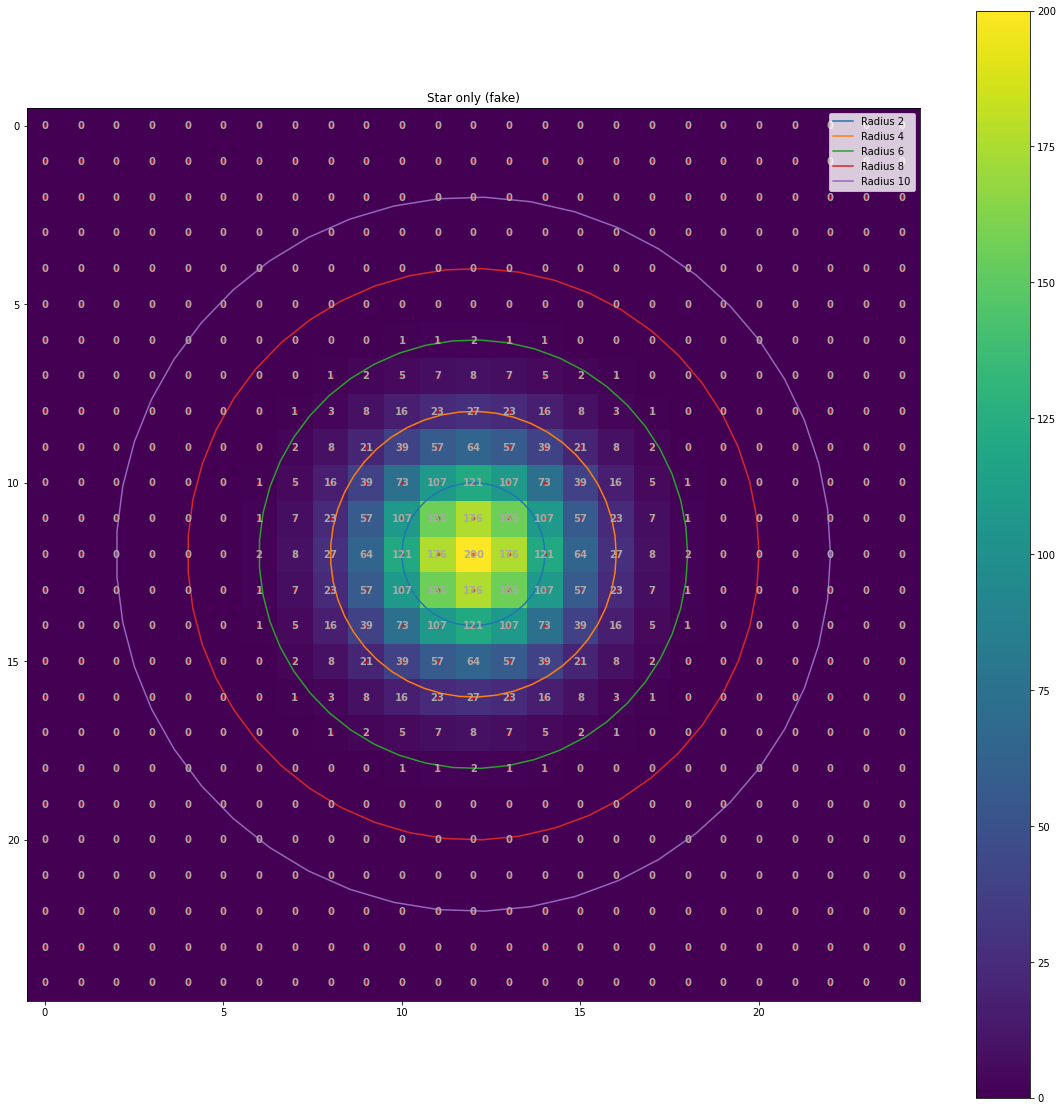

In [13]:
plt.figure(figsize=figure_size)

image_with_pixels_labeled(star_grid, color='darkgray')

for i in range(5):
    radius = 2 + i * 2
    i_circ = circle(*star_center, radius)
    plt.plot(i_circ[0], i_circ[1], label=f'Radius {radius}');
plt.title('Star only (fake)')  
plt.legend()

### Radial profile

In [40]:
rprof = RadialProfile(star_grid, star_center, np.arange(18))  #  - np.median(new_total_image[:8, :8])
cgrow = CurveOfGrowth(star_grid, star_center, np.arange(1, 19))

Text(0.5, 1.0, 'Radial profile: STAR ONLY')

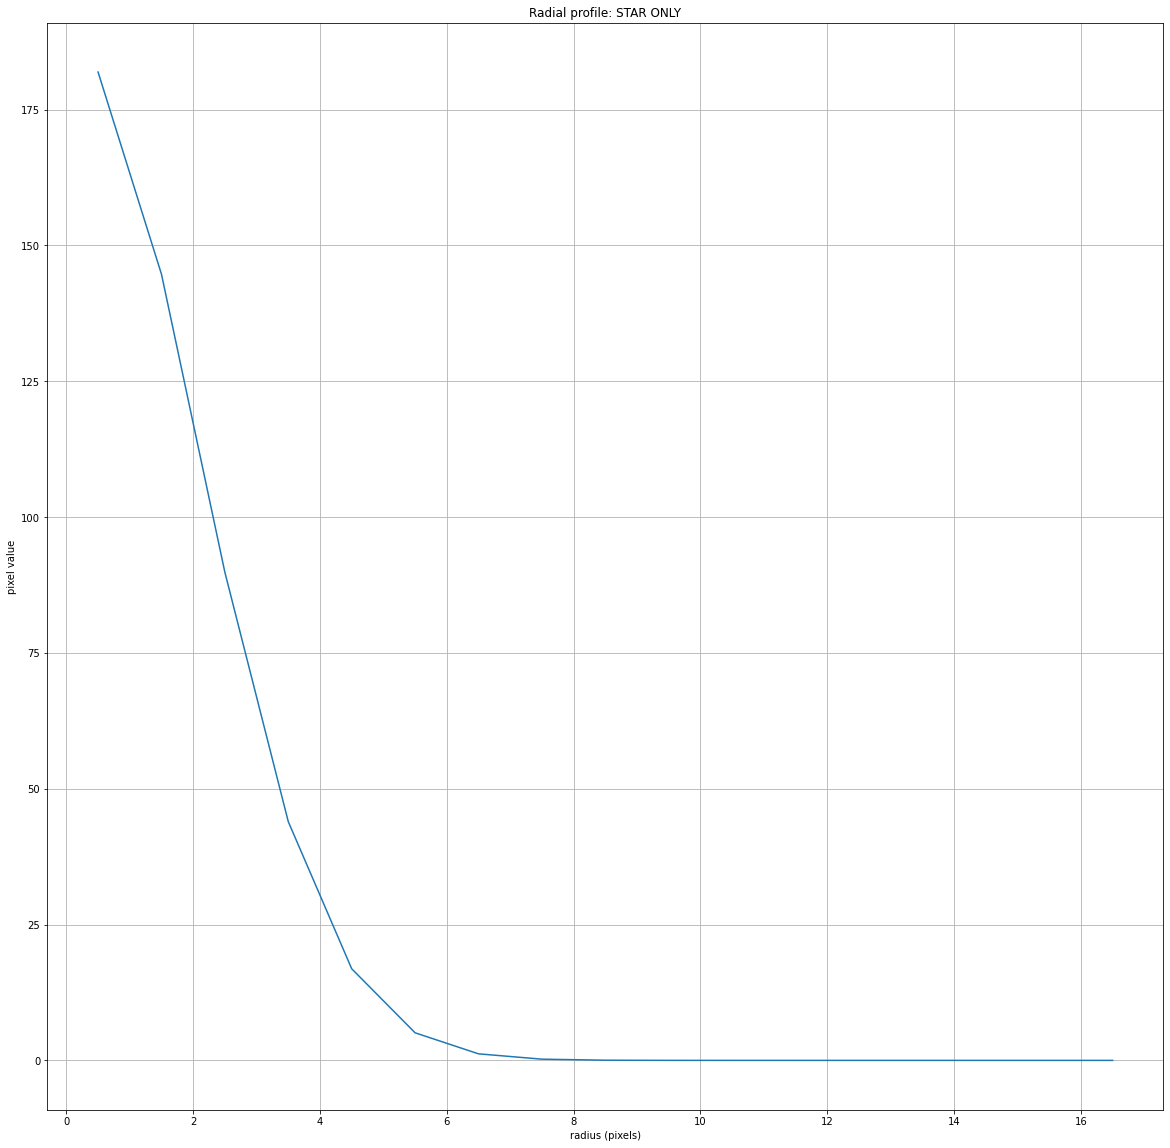

In [41]:
plt.figure(figsize=figure_size)
plt.plot(rprof.radius, rprof.profile)
plt.grid()
plt.xlabel('radius (pixels)')
plt.ylabel('pixel value')
plt.title('Radial profile: STAR ONLY')

### Total counts inside radius (STAR ONLY)

(0.0, 5200.0)

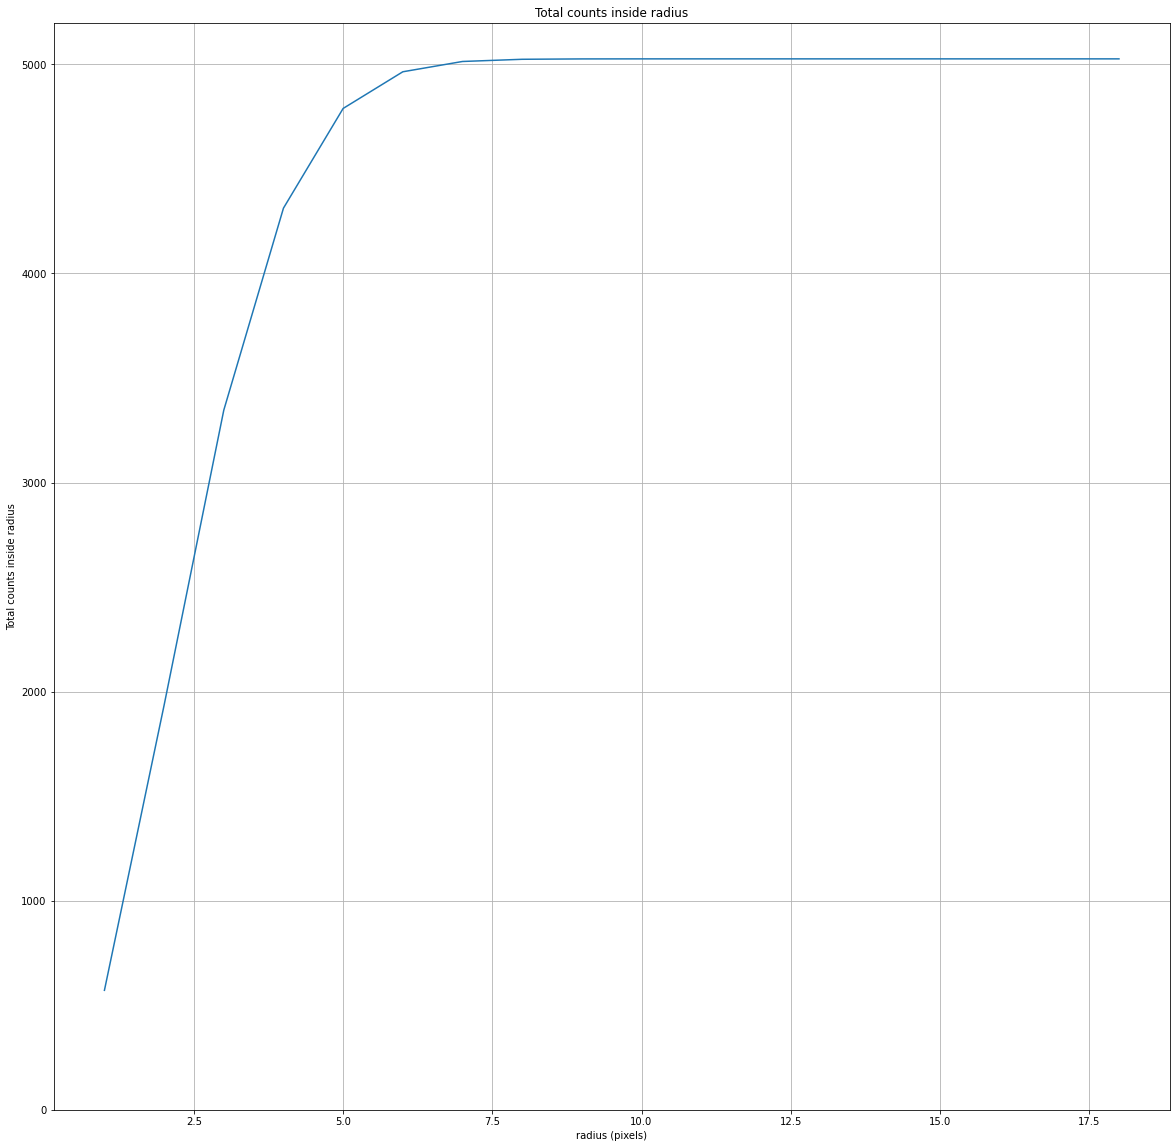

In [43]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, cgrow.profile)
plt.grid()
plt.xlabel('radius (pixels)')
plt.ylabel('Total counts inside radius')
plt.title('Total counts inside radius')
plt.ylim(0, 5200)

In [27]:
signal = cgrow.profile #- 200 * cgrow.area
noise = np.sqrt(signal + (0) * cgrow.area)
signal / noise

array([23.9051015 , 43.99097942, 57.84746209, 65.67044517, 69.20561637,
       70.46142229, 70.80991021, 70.88403593, 70.89640631, 70.89798553,
       70.89814113, 70.89815328, 70.89815399, 70.89815402, 70.89815402,
       70.89815402, 70.89815402, 70.89815402])

Text(0, 0.5, 'Noise')

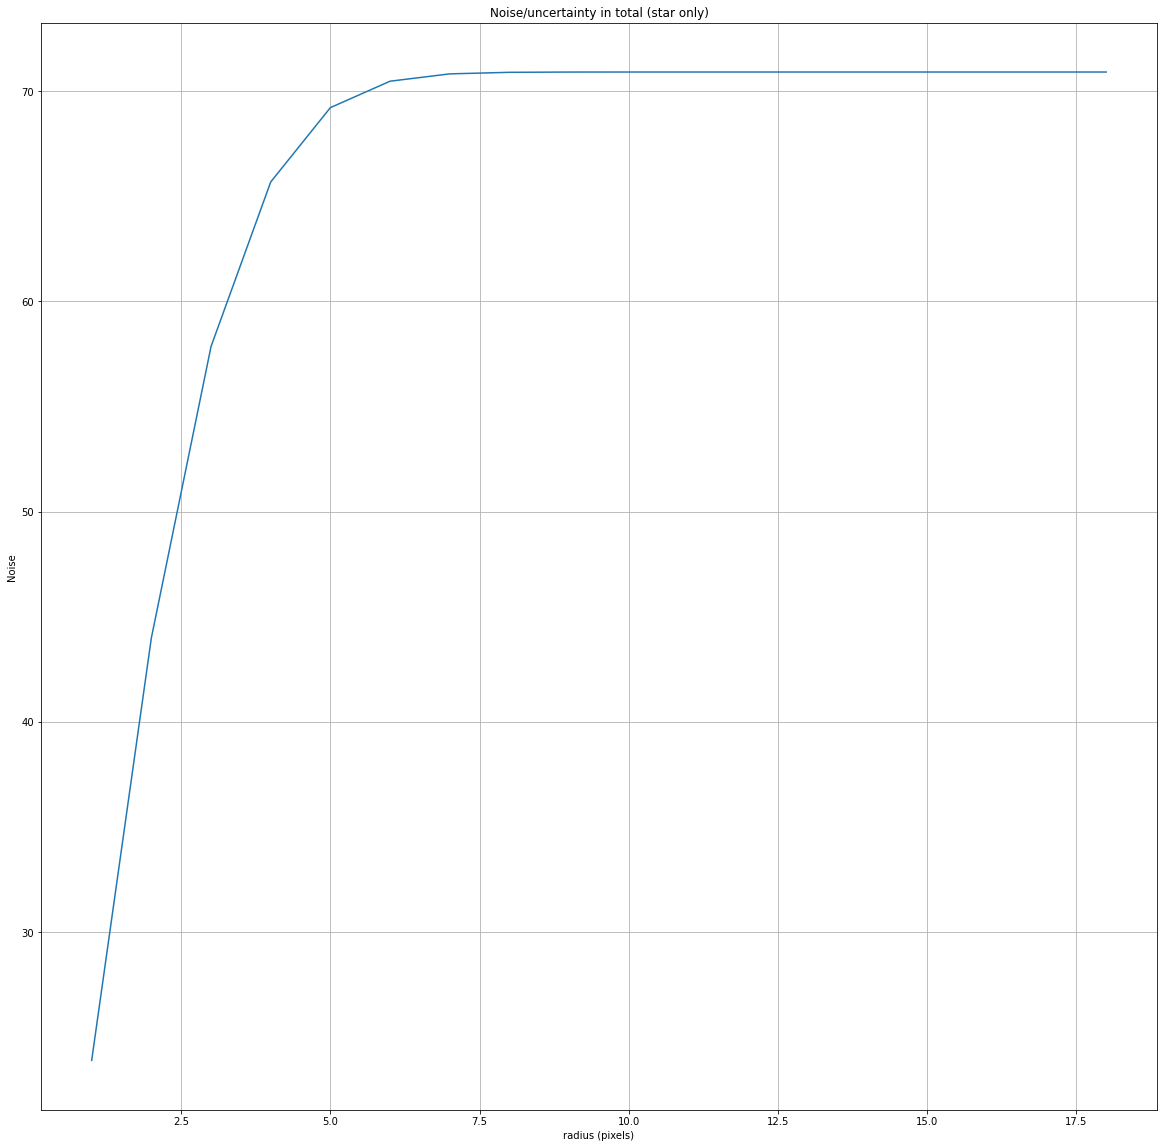

In [44]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, noise)
plt.grid()
plt.xlabel('radius (pixels)')
plt.title('Noise/uncertainty in total (star only)')
plt.ylabel('Noise')
#plt.ylim(0, 5200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Signal to noise ratio')

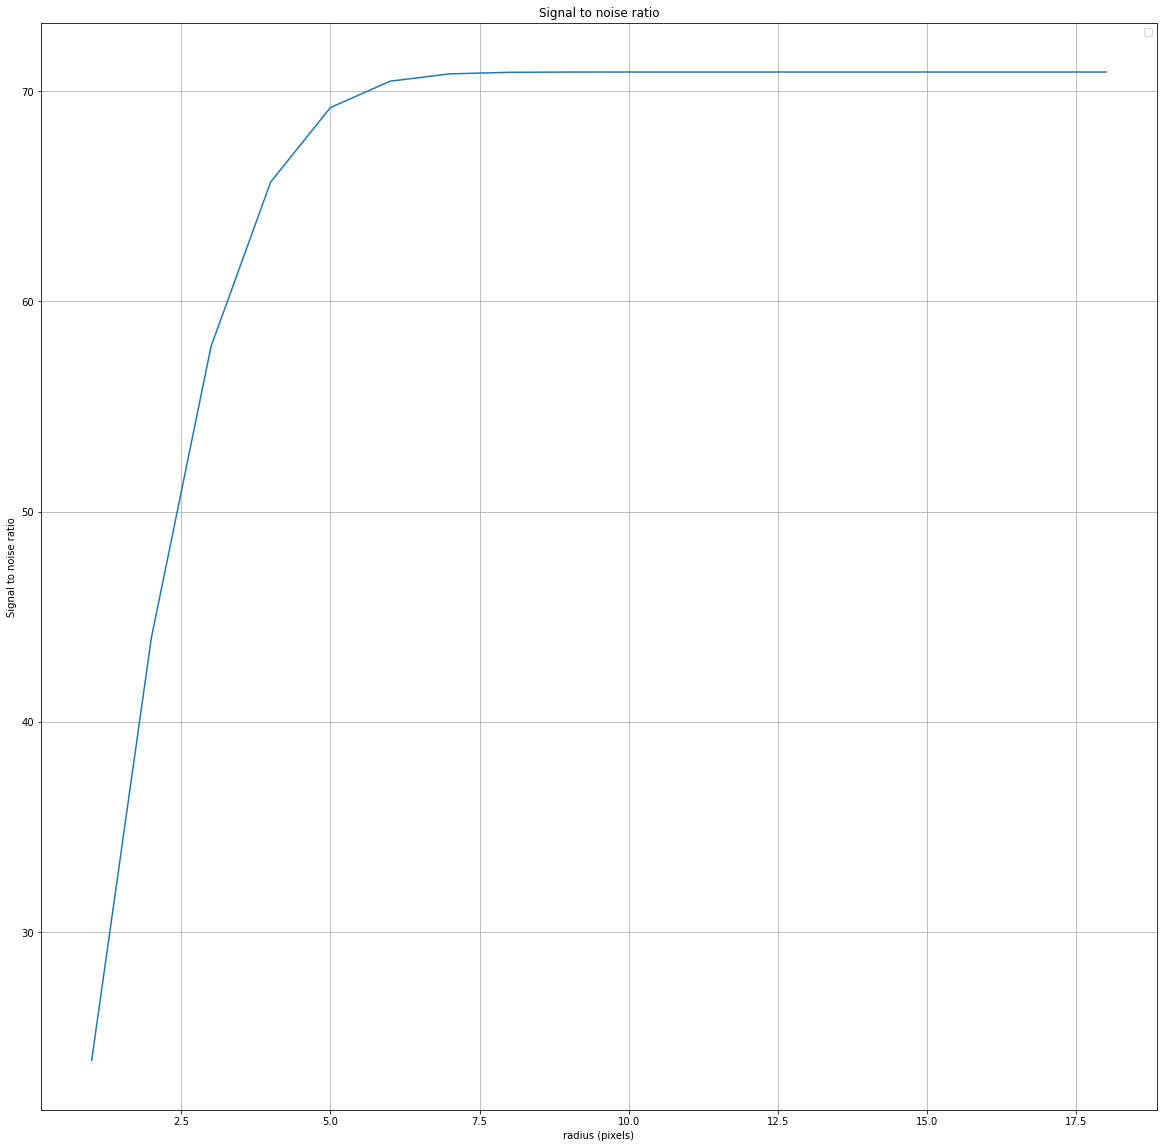

In [45]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, signal / noise)

# for factor in [1.0, 1.4, 2.0]:
#     plt.vlines(factor * fwhm, *plt.ylim(), linestyle='dashed', colors='C1', label=f"{factor:.1f} x FWHM")
plt.grid()
plt.legend()
plt.xlabel('radius (pixels)')
plt.ylabel('Signal to noise ratio')
plt.title('Signal to noise ratio')

## Part 2: Star and noisy background 

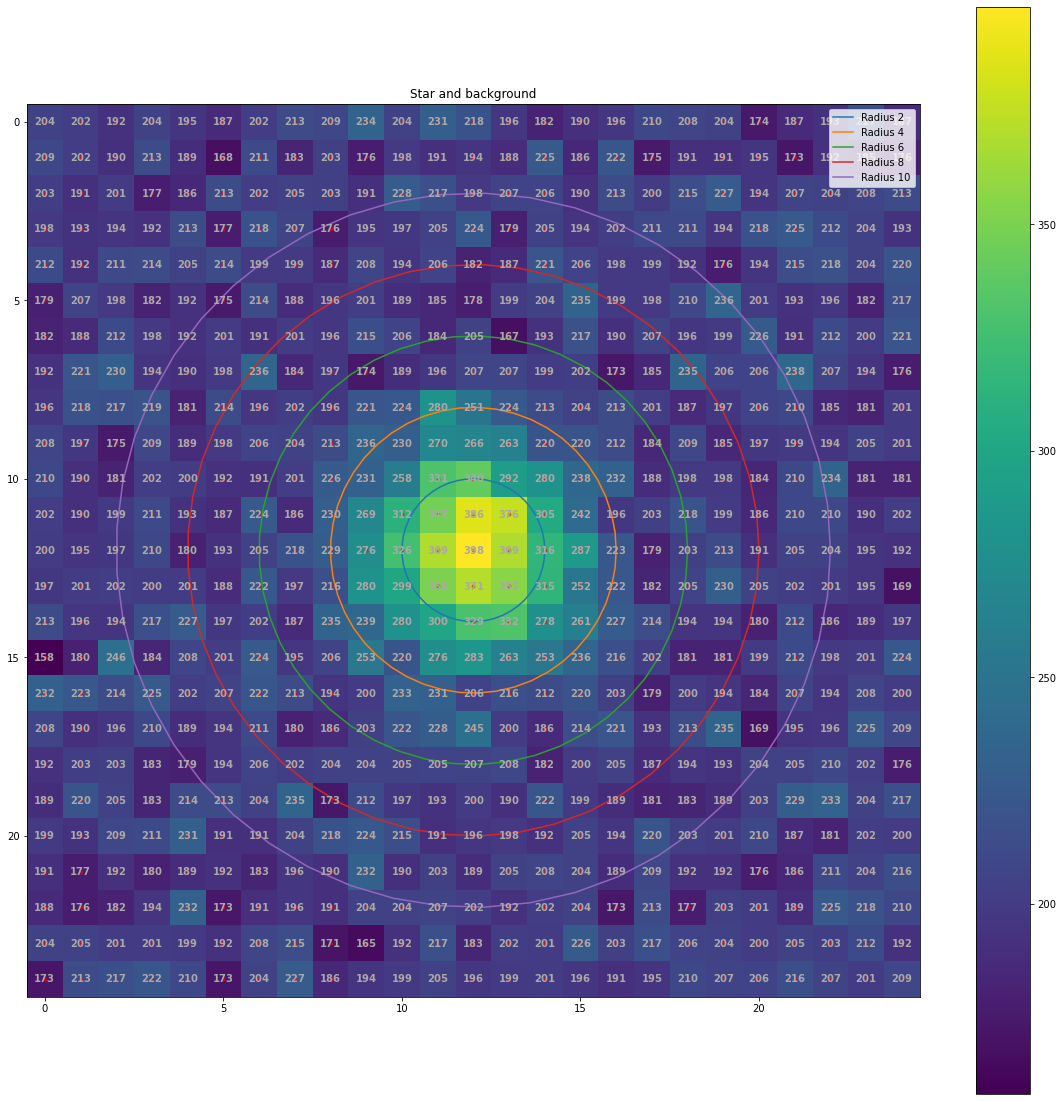

In [39]:
plt.figure(figsize=figure_size)

image_with_pixels_labeled(new_total_image, color='darkgray')

for i in range(5):
    radius = 2 + i * 2
    i_circ = circle(*star_center, radius)
    plt.plot(i_circ[0], i_circ[1], label=f'Radius {radius}');
plt.title('Star and background')  
plt.legend()

In [46]:
rprof = RadialProfile(new_total_image, star_center, np.arange(18))  #  - np.median(new_total_image[:8, :8])
cgrow = CurveOfGrowth(new_total_image, star_center, np.arange(1, 19))

Text(0.5, 1.0, 'Radial profile: STAR AND BACKGROUND')

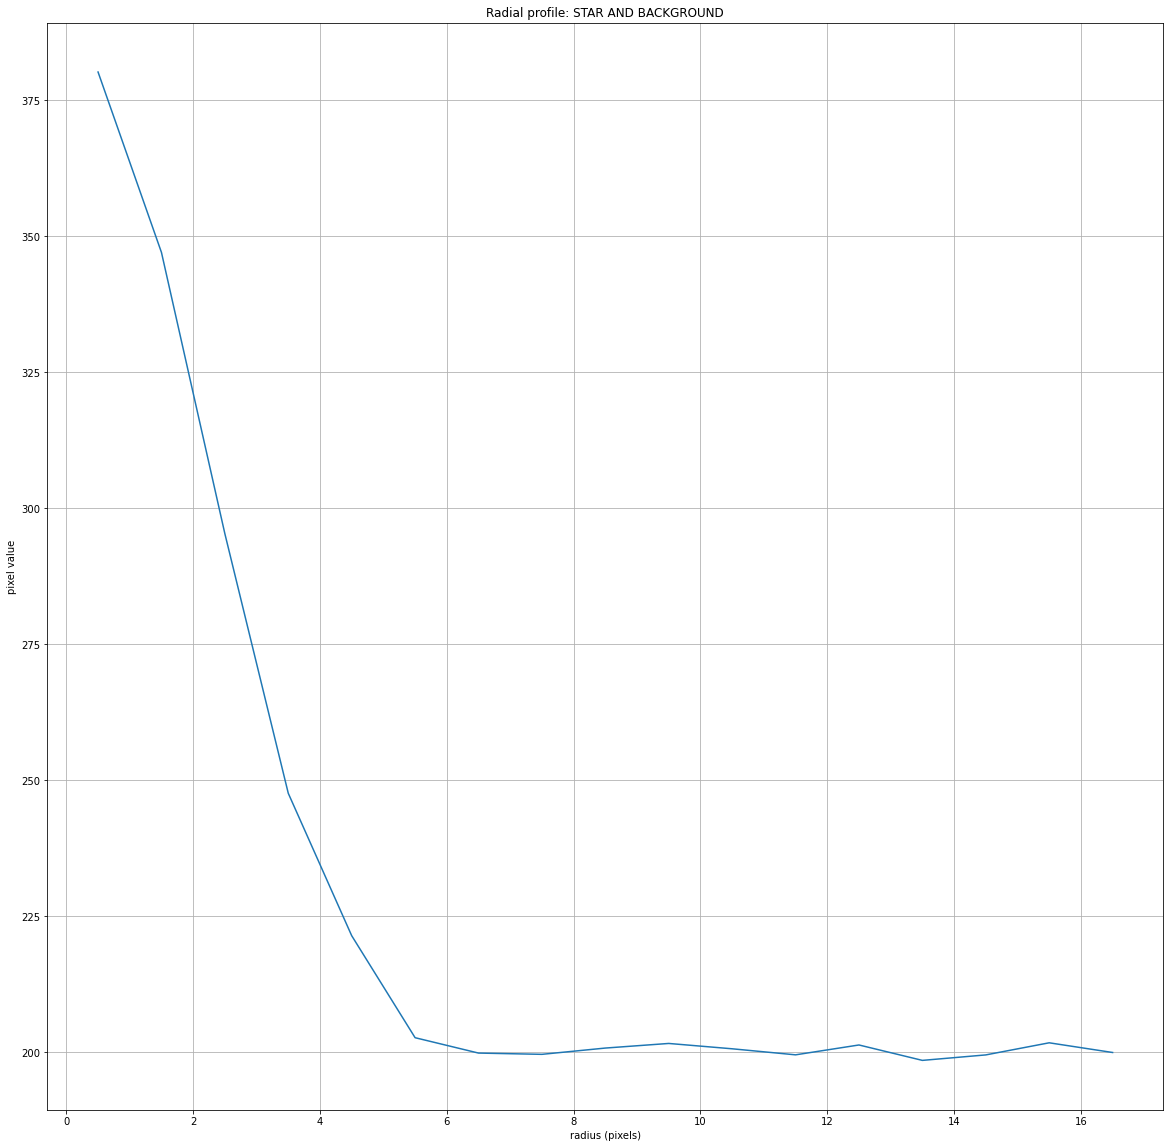

In [48]:
plt.figure(figsize=figure_size)
plt.plot(rprof.radius, rprof.profile)
plt.grid()
plt.xlabel('radius (pixels)')
plt.ylabel('pixel value')
plt.title('Radial profile: STAR AND BACKGROUND')

### Total counts inside radius

Text(0.5, 1.0, 'Total counts inside radius (star and background)')

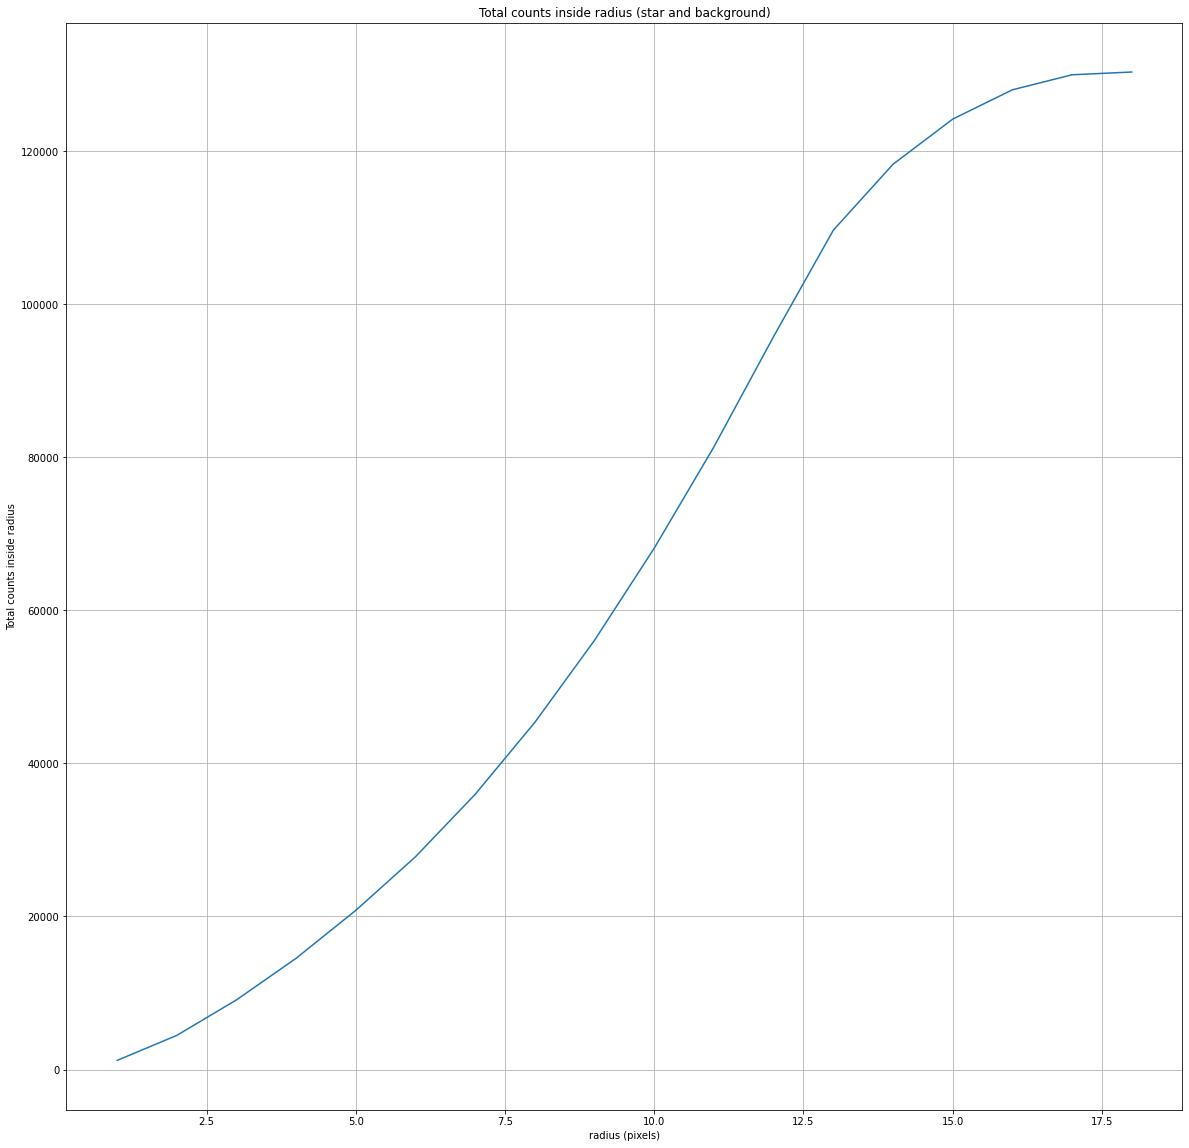

In [50]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, cgrow.profile)
plt.grid()
plt.xlabel('radius (pixels)')
plt.ylabel('Total counts inside radius')
plt.title('Total counts inside radius (star and background)')
#plt.ylim(0, 5200)

In [54]:
signal = cgrow.profile - 200 * cgrow.area
noise = np.sqrt(signal + (200) * cgrow.area)
signal / noise

array([16.37727018, 29.20499617, 36.14387194, 37.2708593 , 35.36637357,
       31.1494379 , 27.36098444, 24.28100002, 22.01650565, 20.35283232,
       18.7764287 , 17.20028269, 16.35747323, 15.56528467, 15.15192075,
       15.01681906, 14.90230703, 14.8469115 ])

Text(0, 0.5, 'Noise')

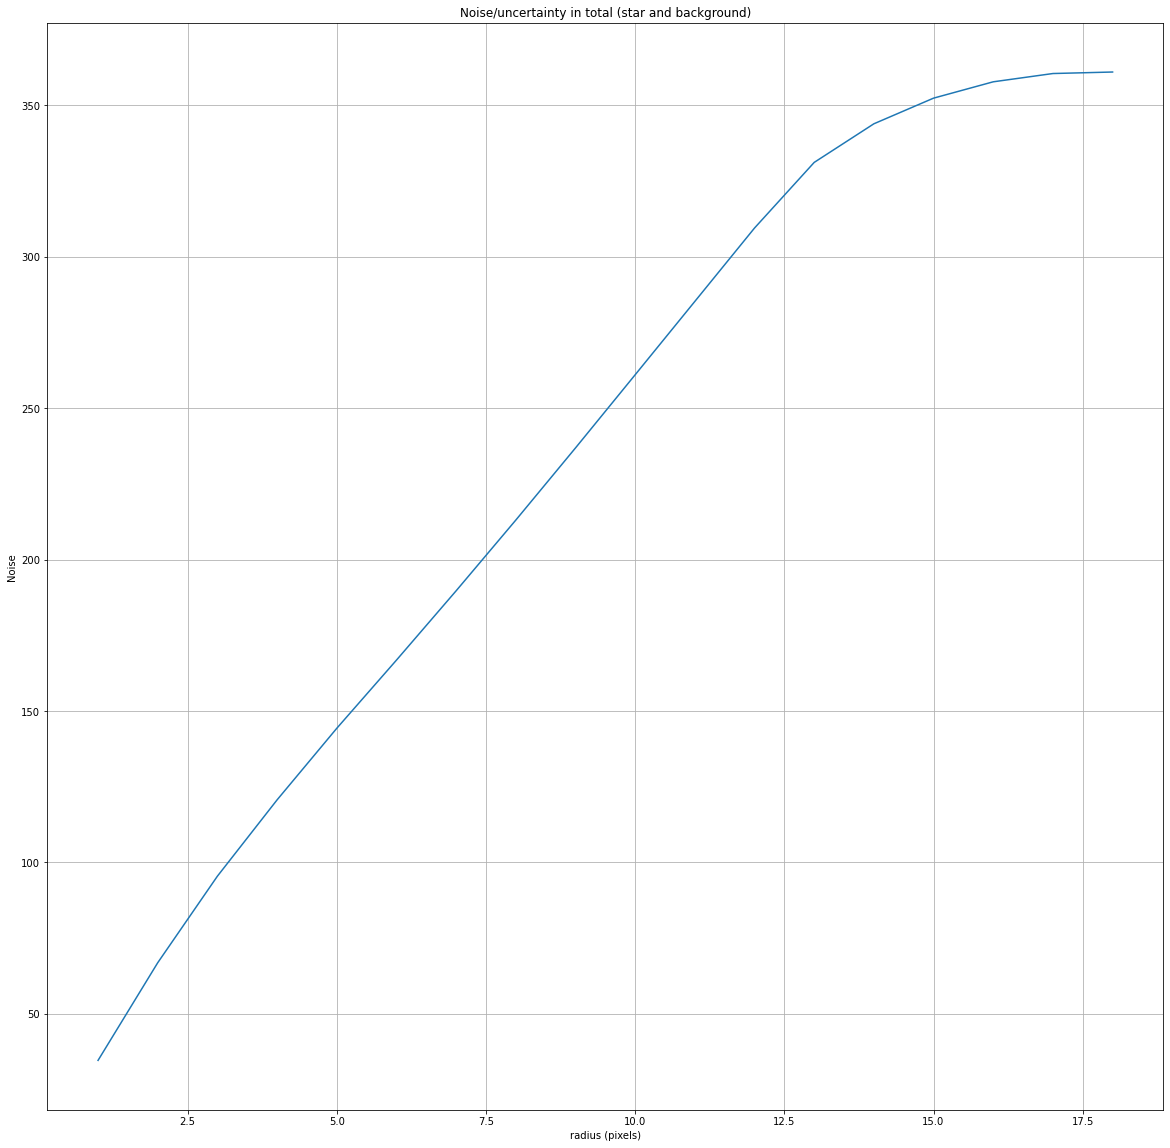

In [55]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, noise)
plt.grid()
plt.xlabel('radius (pixels)')
plt.title('Noise/uncertainty in total (star and background)')
plt.ylabel('Noise')
#plt.ylim(0, 5200)

Text(0.5, 1.0, 'Signal to noise ratio (star and background)')

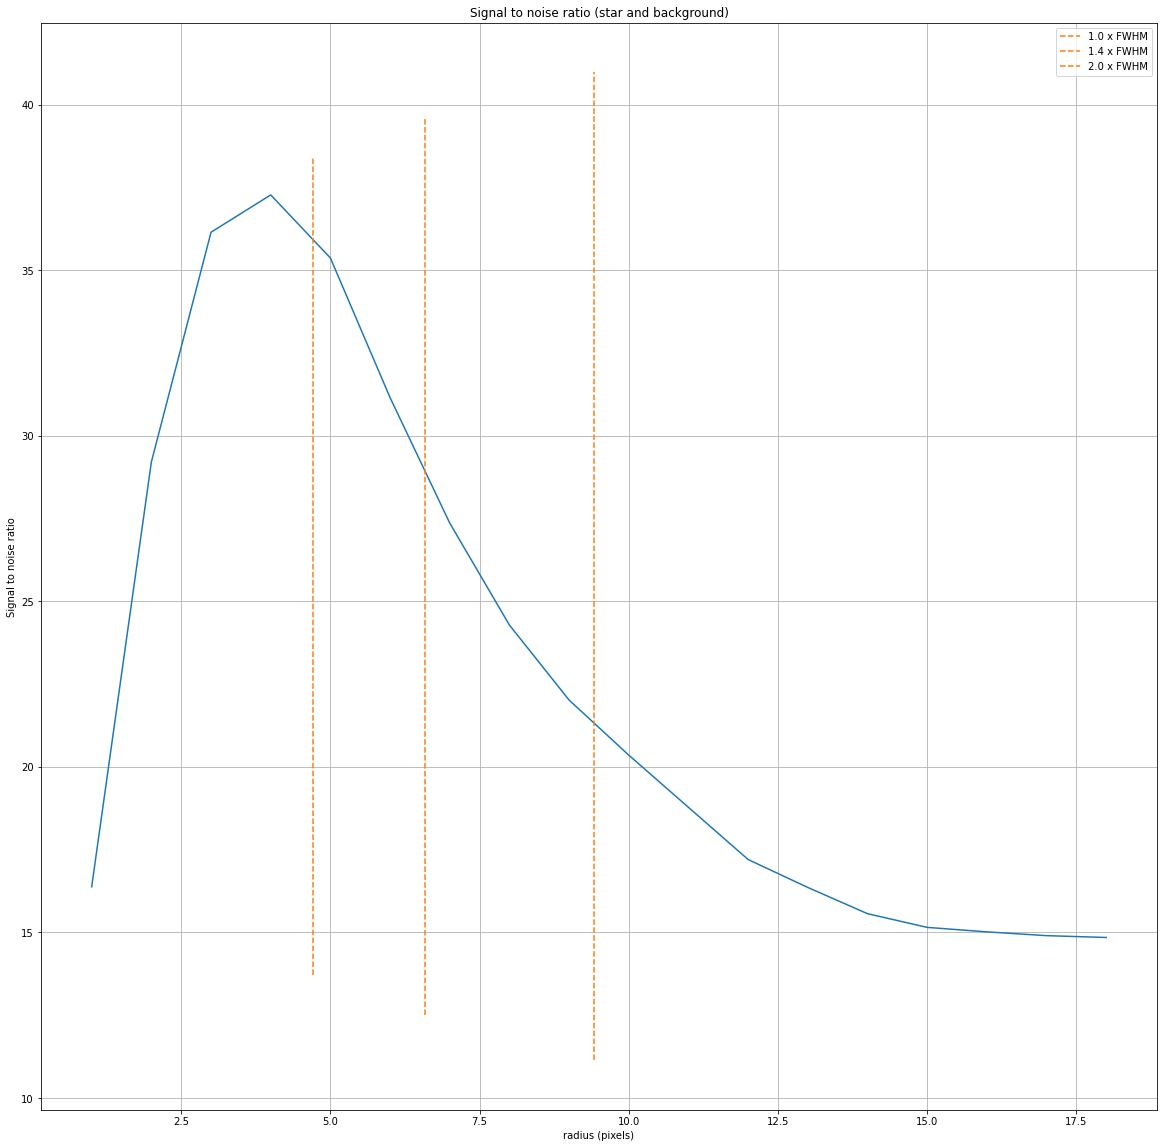

In [57]:
plt.figure(figsize=figure_size)
plt.plot(cgrow.radius, signal / noise)

# for factor in [1.0, 1.4, 2.0]:
#     plt.vlines(factor * fwhm, *plt.ylim(), linestyle='dashed', colors='C1', label=f"{factor:.1f} x FWHM")
    
plt.grid()
plt.legend()
plt.xlabel('radius (pixels)')
plt.ylabel('Signal to noise ratio')
plt.title('Signal to noise ratio (star and background)')

34.55751918948772